# Forecasting - FB Prophet
https://facebook.github.io/prophet/

https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/

https://peerj.com/preprints/3190.pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import io # This is for google colab, change it for jupter





%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

In [2]:
from fbprophet import Prophet

In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')

**Trivial Forecast (rolling mean)**

In [4]:
df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean() # take the window and write the average as the result

In [5]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


In [7]:
from google.colab import files
uploaded = files.upload()  # This is for google colab, change it for jupter

Saving COVID_small_flat_table.csv to COVID_small_flat_table (3).csv


**Small data set**

In [8]:
df_all = pd.read_csv(io.BytesIO(uploaded['COVID_small_flat_table.csv']),sep=';') # This is for google colab, change it for jupter
df=df_all[['date','Germany']]
df=df.rename(columns={'date': 'ds',
                        'Germany': 'y'})

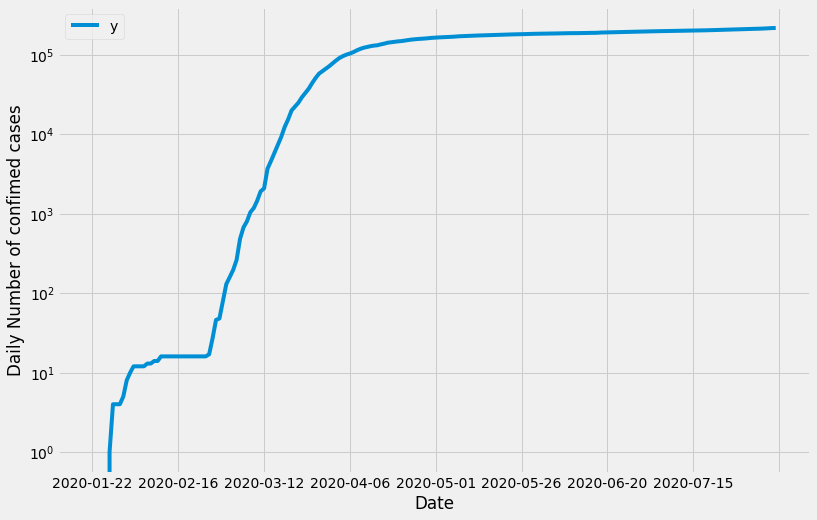

In [9]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()

In [10]:
#my_model = Prophet(interval_width=0.95)
my_model = Prophet(growth='logistic') 

In [11]:
df['cap']=1000000.
my_model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
future_dates = my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap']=1000000.
future_dates.tail()

,ds,cap
202,2020-08-11,1000000.0
203,2020-08-12,1000000.0
204,2020-08-13,1000000.0
205,2020-08-14,1000000.0
206,2020-08-15,1000000.0


In [13]:
forecast = my_model.predict(future_dates)

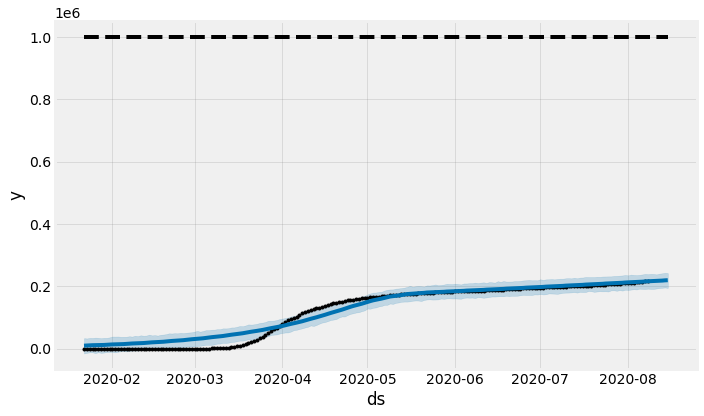

In [14]:
my_model.plot(forecast,
              uncertainty=True );

In [15]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [16]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,10187.299829,1000000.0,-15157.775735,34034.254982,10187.299829,10187.299829,-296.453095,-296.453095,-296.453095,-296.453095,-296.453095,-296.453095,0.0,0.0,0.0,9890.846734
1,2020-01-23,10485.312407,1000000.0,-13031.061699,32973.211928,10485.312407,10485.312407,-27.329958,-27.329958,-27.329958,-27.329958,-27.329958,-27.329958,0.0,0.0,0.0,10457.982449
2,2020-01-24,10791.947798,1000000.0,-11427.772500,34713.848967,10791.947798,10791.947798,296.986665,296.986665,296.986665,296.986665,296.986665,296.986665,0.0,0.0,0.0,11088.934463
3,2020-01-25,11107.449861,1000000.0,-11313.973264,34558.892926,11107.449861,11107.449861,247.723800,247.723800,247.723800,247.723800,247.723800,247.723800,0.0,0.0,0.0,11355.173661
4,2020-01-26,11432.069015,1000000.0,-13996.454950,35620.634083,11432.069015,11432.069015,31.276174,31.276174,31.276174,31.276174,31.276174,31.276174,0.0,0.0,0.0,11463.345189


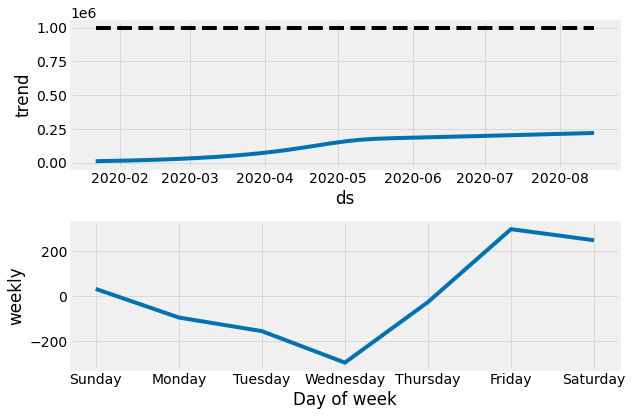

In [17]:
my_model.plot_components(forecast);

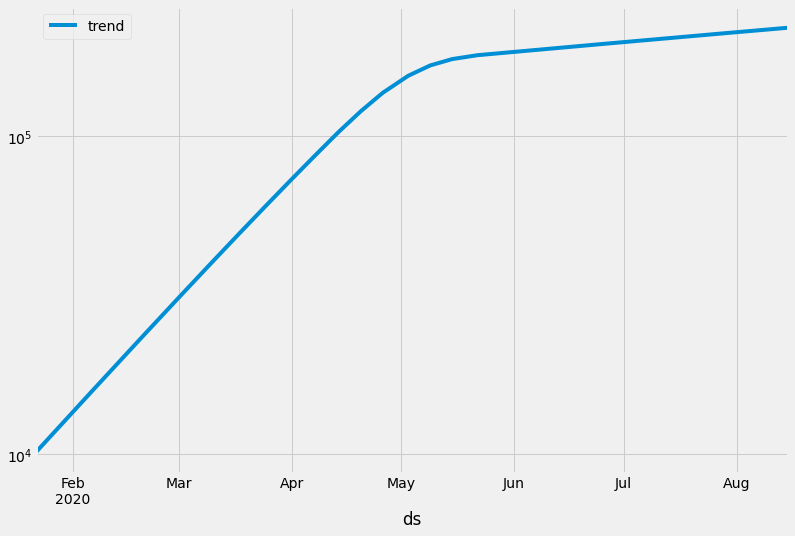

In [18]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

In [19]:
# Cross Validation

In [20]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='30 days', # we take the first 30 days for training
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days')
df_cv.head()

INFO:fbprophet:Making 163 forecasts with cutoffs between 2020-02-21 00:00:00 and 2020-08-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-22,22.076242,18.268745,26.114516,16,2020-02-21
1,2020-02-23,23.519245,19.770446,27.373260,16,2020-02-21
2,2020-02-24,25.000404,20.680548,28.896186,16,2020-02-21
3,2020-02-25,27.021807,23.156043,30.870937,17,2020-02-21
4,2020-02-26,26.875514,22.772912,30.607342,27,2020-02-21


In [21]:
df_cv.sort_values(by=['cutoff','ds'])[0:14]


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-22,22.076242,18.268745,26.114516,16,2020-02-21
1,2020-02-23,23.519245,19.770446,27.373260,16,2020-02-21
2,2020-02-24,25.000404,20.680548,28.896186,16,2020-02-21
3,2020-02-25,27.021807,23.156043,30.870937,17,2020-02-21
4,2020-02-26,26.875514,22.772912,30.607342,27,2020-02-21
5,2020-02-27,27.816130,24.085834,31.827195,46,2020-02-21
6,2020-02-28,29.208535,25.318372,33.206929,48,2020-02-21
7,2020-02-23,22.409863,18.539683,26.496012,16,2020-02-22
8,2020-02-24,23.790939,19.805707,28.147549,16,2020-02-22
9,2020-02-25,25.704727,21.475128,29.385398,17,2020-02-22


In [22]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [23]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.609040e+09,40112.841754,31959.444658,0.244572,0.269109,0.147239
1,2 days,1.898086e+09,43567.026622,35321.177450,0.277987,0.308490,0.134969
2,3 days,2.243088e+09,47361.247425,38962.338069,0.313956,0.343892,0.128834
3,4 days,2.656905e+09,51545.171640,42918.741690,0.345770,0.378378,0.122699
4,5 days,3.156260e+09,56180.604026,47233.956731,0.381375,0.406591,0.122699
5,6 days,3.762601e+09,61340.040163,51947.210541,0.424620,0.434983,0.116564
6,7 days,4.504242e+09,67113.649347,57109.202973,0.468308,0.466509,0.116564


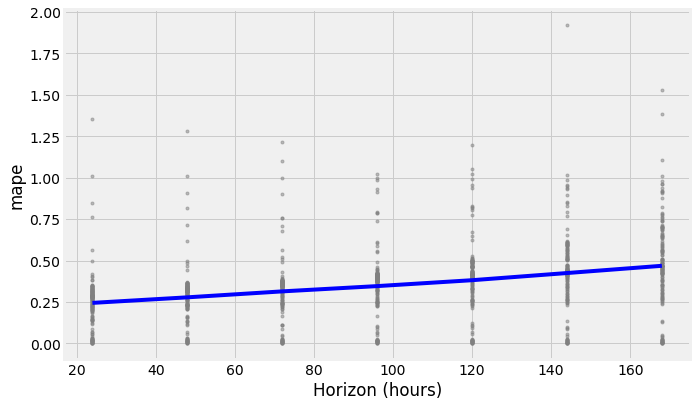

In [24]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

In [25]:
# Diagonal Plot

In [26]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [27]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
1112,2020-08-04,211552.025157,190462.063198,231665.509678,212828,2020-07-28,7 days
1119,2020-08-05,214628.195029,191088.679386,238563.134549,214113,2020-07-29,7 days
1126,2020-08-06,215832.818874,190788.111183,240338.101178,215039,2020-07-30,7 days
1133,2020-08-07,215061.551544,200287.058480,229828.378375,216196,2020-07-31,7 days
1140,2020-08-08,213379.003279,194670.027741,232445.155229,216903,2020-08-01,7 days


In [28]:
type(df_cv['horizon'][0]) 


pandas._libs.tslibs.timedeltas.Timedelta

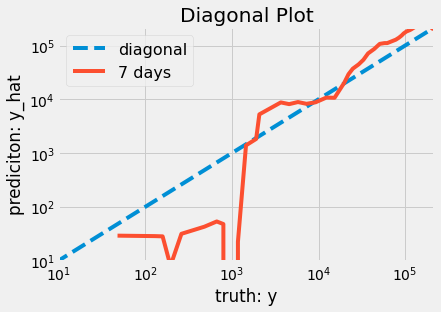

In [29]:
fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

In [37]:
# Trivial Forecast

In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
parse_dates=['date']
df_all = pd.read_csv(io.BytesIO(uploaded['COVID_small_flat_table.csv']),sep=';',parse_dates=parse_dates) #Change it forjupyter
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

In [41]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean()

In [43]:

df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 151.32597320373898


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.000000,NaT,NaN,NaT
3,2020-01-25,0,0.000000,NaT,NaN,NaT
4,2020-01-26,0,0.000000,NaT,NaN,NaT
5,2020-01-27,1,0.333333,NaT,NaN,NaT
6,2020-01-28,4,1.666667,NaT,NaN,NaT
7,2020-01-29,4,3.000000,2020-01-22,NaN,7 days
8,2020-01-30,4,4.000000,2020-01-23,NaN,7 days
9,2020-01-31,5,4.333333,2020-01-24,0.000000,7 days
